In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pesosi/model_vi_incertidumnbre.hdf5
/kaggle/input/pesosi/model_nobay_incertidumnbre.hdf5
/kaggle/input/muestrasi/samples.npz


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import cv2
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from keras import layers, Model, models, callbacks, applications
from tensorflow_probability import layers as tfp_layers

376

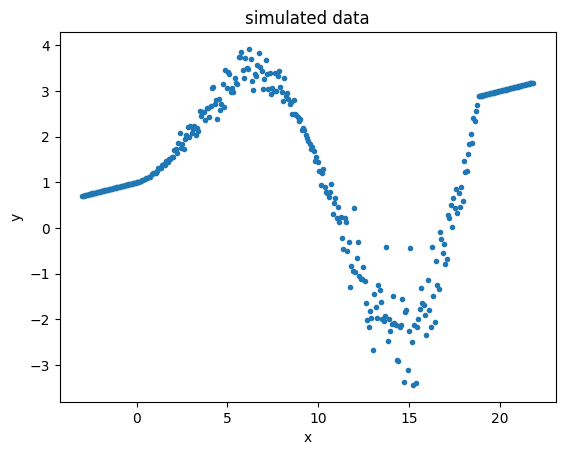

In [ ]:
def create_sine_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n) #valores entre 0 y 2pi
    y1 = x*np.sin(x) #f(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60))) #se añaden 60 ceros al principio y al final del array
    #Ademas a los puntos de f(x) se les añade un ruido gaussiano
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    #se añaden 60 puntos a x en el intervalo [-3,0] y otros 60 en el [2pi, 2pi+3]
    y2 = 0.1*x+1
    y=y1+y2 #y es la suma de la funcion con ruido gaussiano y la recta.
    return x,y
x,y = create_sine_data(256) # Note that the model has been trained with 2048 data points
plt.scatter(x=x,y=y,marker='.',alpha=1)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)
n

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.24.0
TF  Version 2.17.1


In [ ]:
from tensorflow_probability.python.internal import tf_keras

In [ ]:
from tf_keras.layers import Input
from tf_keras.layers import Dense
from tf_keras.layers import Concatenate
from tf_keras.models import Model
from tf_keras.optimizers import Adam

def NLL(y, distr):
  return -distr.log_prob(y) #PROBLEMAS DE REGRESION -> LOG VEROSIMILITUD

def normal_sp(params): #crea la normal a partir de los params
  #params[:,0:1] media, params[:,1:2] desviacion estandar (softolus hace qe sea positivo) y se suma algo para que no sea 0
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden) #devuelve la media y la varianza
distribucion = tfp.layers.DistributionLambda(normal_sp)(params) #convierte los parametros a una normal

model_nobay = Model(inputs=inputs, outputs=distribucion)
model_nobay.compile(Adam(), loss=NLL)

In [ ]:
model_nobay.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

In [ ]:
#history = model_nobay.fit(x, y, epochs=5000, verbose=0,batch_size=32)
#plt.plot(history.history['loss'])
#plt.legend(['loss'])
#plt.ylabel('NLL')
#plt.xlabel('Epochs')
#plt.show()

In [ ]:
#model_nobay.save_weights("model_nobay_incertidumnbre.hdf5")

In [ ]:
model_nobay.load_weights("/kaggle/input/pesosi/model_nobay_incertidumnbre.hdf5")

In [ ]:
x_pred = np.arange(-10,30,0.3) #Se crea un array con valores entre -10 y 30 con un paso de 0.3
for rep in range(2): #Predictions for two runs
    print(model_nobay.predict(x_pred)[0:3].T) #muestra las 3 primeras predicciones de cada ejecucion traspuestas

5/5 [==============================] - 1s 6ms/step
[[0.29621422 0.30387414 0.31584245]]
5/5 [==============================] - 0s 2ms/step
[[0.2983125  0.30586705 0.31508067]]


In [ ]:
from tqdm import tqdm_notebook as tqdm
runs = 200
nobay_cpd =np.zeros((runs,len(x_pred))) #matriz que guarda los resultados -> para cada x de x_pred, guardamos 200 predicciones suyas
for i in tqdm(range(0,runs)):
    nobay_cpd[i,:]=np.reshape(model_nobay.predict(x_pred),len(x_pred))

<ipython-input-12-2026dcac98ec>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,runs)):


  0%|          | 0/200 [00:00<?, ?it/s]

5/5 [==============================] - 0s 2ms/step


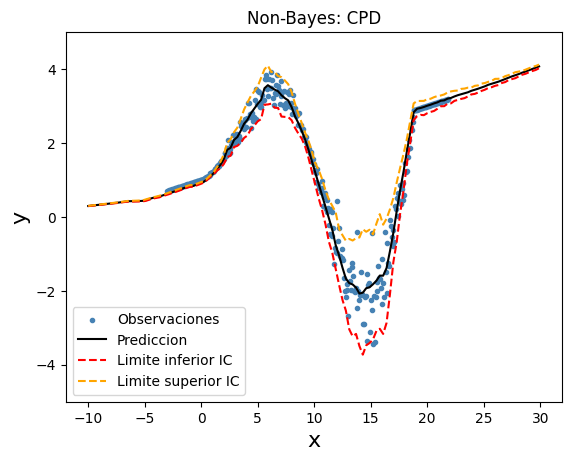

In [ ]:
def make_plot_runs_avg(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.', label = "Observaciones") #observaciones reales
    ax.set_ylim(ylim)
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=1.5, label="Prediccion") #para cada x de x_pred plotea la media de sus 200 predicciones
    #Ploteamos los intervalos de confianza al 95%
    ax.plot(x_pred,np.quantile(preds, 0.025, axis=0),color="red",linewidth=1.5,linestyle="--", label="Limite inferior IC")  #percentil 2,5, limite inferior del IC
    ax.plot(x_pred,np.quantile(preds, 0.975, axis=0),color="orange",linewidth=1.5,linestyle="--", label="Limite superior IC") #percentil 97.5, limite superior del IC
    ax.legend()

ax = plt.subplot()
make_plot_runs_avg(ax, nobay_cpd)
plt.ylim([-5,5])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: CPD')
plt.show()

**INFERENCIA VARIACIONAL**

In [ ]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0002), loss=NLL)

model_params = Model(inputs=inputs, outputs=params)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
model_vi.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipou  (None, 20)                80        
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 50)                2100      
 out)                                                            
                                                                 
 dense_flipout_2 (DenseFlip  (None, 20)                2040      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 2)                 84        
 out)                                                      

In [ ]:
#history = model_vi.fit(x, y, epochs=20000, verbose=0,batch_size=512)
#model_vi.save_weights('model_vi.hdf5')
#plt.plot(history.history['loss'])
#plt.legend(['loss'])
#plt.ylabel('NLL')
#plt.xlabel('Epochs')
#plt.ylim([0,20])
#model_vi.save_weights('model_vi.hdf5')
#plt.show()

In [ ]:
#model_vi.save_weights("model_vi_incertidumnbre.hdf5")

In [ ]:
model_vi.load_weights("/kaggle/input/pesosi/model_vi_incertidumnbre.hdf5")

In [ ]:
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

<ipython-input-20-2f099d2229c1>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,runs)):


  0%|          | 0/200 [00:00<?, ?it/s]

5/5 [==============================] - 0s 3ms/step


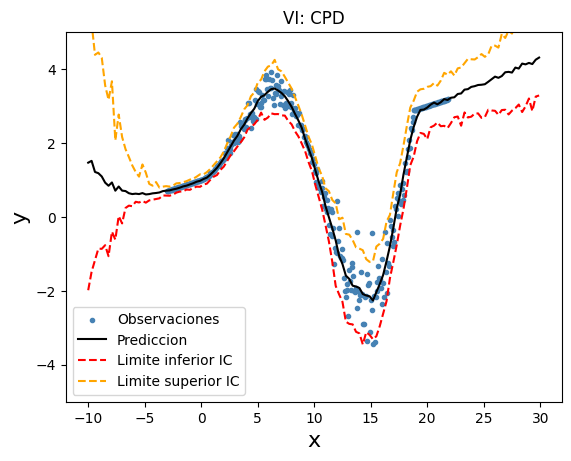

In [ ]:
ax = plt.subplot()
make_plot_runs_avg(ax, vi_cpd)
plt.ylim([-5,5])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('VI: CPD')
plt.show()

## NUTS

In [ ]:
def bayesian_nn_model():
  """"Definimos la red neuronal, donde cada peso y cada sesgo será una variable aleatoria normal, inicialmente estandares.
  Construimos las capas de la red a partir de estos pesos y sesgos
  La salida sera una normal centrada en la prediccion mu y su desviacion estandar sigma""""
    x = tf.convert_to_tensor(x_train.reshape(-1, 1), dtype=tf.float32)

    # Capa 1
    w1 = yield tfp.distributions.Normal(loc=tf.zeros([1, 20]), scale=1.0, name="w1")
    b1 = yield tfp.distributions.Normal(loc=tf.zeros([20]), scale=1.0, name="b1")
    hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1)

    # Capa 2
    w2 = yield tfp.distributions.Normal(loc=tf.zeros([20, 50]), scale=1.0, name="w2")
    b2 = yield tfp.distributions.Normal(loc=tf.zeros([50]), scale=1.0, name="b2")
    hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)

    # Capa 3
    w3 = yield tfp.distributions.Normal(loc=tf.zeros([50, 20]), scale=1.0, name="w3")
    b3 = yield tfp.distributions.Normal(loc=tf.zeros([20]), scale=1.0, name="b3")
    hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)

    # Salida
    w_out = yield tfp.distributions.Normal(loc=tf.zeros([20, 1]), scale=1.0, name="w_out")
    b_out = yield tfp.distributions.Normal(loc=tf.zeros([1]), scale=1.0, name="b_out")

    mu = tf.matmul(hidden3, w_out) + b_out
    sigma = yield tfp.distributions.HalfNormal(0.5, name="sigma")

    # Observación de y
    yield tfp.distributions.Normal(loc=mu, scale=sigma, name="y")

# Convertimos la red bayesiana en un modelo probabilistico completo sobre el cual haremos NUTS
joint_model = tfp.distributions.JointDistributionCoroutineAutoBatched(bayesian_nn_model)

# Calcula la Log-probabilidad del modelo
def target_log_prob_fn(w1, b1, w2, b2, w3, b3, w_out, b_out, sigma):
    return joint_model.log_prob((w1, b1, w2, b2, w3, b3, w_out, b_out, sigma, y_train.reshape(-1, 1)))

# Configurar el muestreador NUTS
nuts = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.01
)

# Hacemos que el tamaño de paso se ajuste automaticamente
tuning = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=nuts,
    num_adaptation_steps=20
)

# Ejecutar el muestreo
num_burnin = 10
num_samples = 1000

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin,
        current_state=[tf.zeros([1, 20]), tf.zeros([20]), tf.zeros([20, 50]), tf.zeros([50]),
                       tf.zeros([50, 20]), tf.zeros([20]), tf.zeros([20, 1]), tf.zeros([1]), tf.ones([])],
        kernel=tuning,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )

#Esto nos da una cadena de muestras posteriores para los pesos, los sesgos y los sigmas



#samples, is_accepted = run_chain()

# Evaluar los resultados
#acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
#print("Tasa de aceptación:", acceptance_rate.numpy())

# Extraer muestras
#(w1_samples, b1_samples, w2_samples, b2_samples,
# w3_samples, b3_samples, w_out_samples, b_out_samples, sigma_samples) = samples

In [ ]:
#np.savez("/content/drive/MyDrive/TFG/weights/samples.npz",
#         w1=w1_samples, b1=b1_samples,
#         w2=w2_samples, b2=b2_samples,
#         w3=w3_samples, b3=b3_samples,
#         w_out=w_out_samples, b_out=b_out_samples,
#         sigma=sigma_samples)

In [ ]:
loaded_samples = np.load("/kaggle/input/muestrasi/samples.npz")
w1_samples = loaded_samples["w1"]
b1_samples = loaded_samples["b1"]
w2_samples = loaded_samples["w2"]
b2_samples = loaded_samples["b2"]
w3_samples = loaded_samples["w3"]
b3_samples = loaded_samples["b3"]
w_out_samples = loaded_samples["w_out"]
b_out_samples = loaded_samples["b_out"]
sigma_samples = loaded_samples["sigma"]

In [ ]:
#Utilizando las muestras de la posterior de los pesos anteriores, realizamos las predicciones
#a traves de la red bayesiana con esos pesos y sesgos
def predict(x_pred, samples):
    (w1, b1, w2, b2, w3, b3, w_out, b_out, sigma) = samples

    hidden1 = tf.nn.relu(tf.matmul(x_pred, w1) + b1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
    hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)
    mu = tf.matmul(hidden3, w_out) + b_out

    return mu

In [ ]:
mcmc_cpd = np.zeros((num_samples, len(x_pred)))

In [ ]:
for i in range(num_samples):
    sample_params = (w1_samples[i], b1_samples[i], w2_samples[i], b2_samples[i],
                     w3_samples[i], b3_samples[i], w_out_samples[i], b_out_samples[i], sigma_samples[i])
    mcmc_cpd[i, :] = predict(x_pred.reshape(-1, 1).astype(np.float32), sample_params).numpy().flatten()

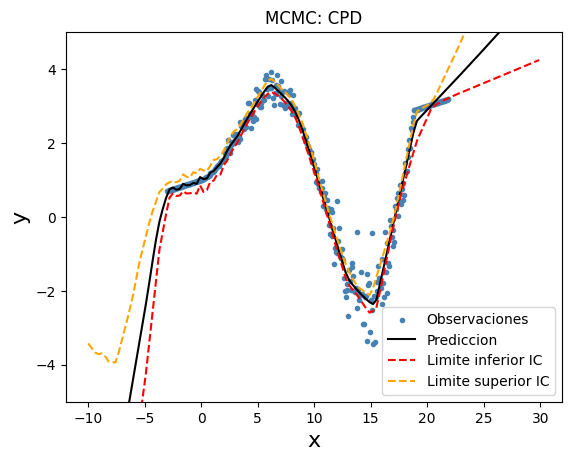

In [ ]:
ax = plt.subplot()
make_plot_runs_avg(ax, mcmc_cpd)
plt.ylim([-5,5])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('MCMC: CPD')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def make_plot_runs(ax, preds, alpha_data=0.6, ylim=[-7, 8]):
    """Dibuja múltiples predicciones como líneas finas junto con los datos observados."""
    ax.scatter(x, y, color="steelblue", alpha=alpha_data, marker='.', label="Observaciones")
    ax.plot(x_pred, preds.T, color="dimgray", linewidth=0.5, alpha=0.3 )
    ax.set_ylim(ylim)
    ax.set_title("Distribución de Predicciones")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)


def make_plot_runs_avg(ax, preds, alpha_data=0.6, ylim=[-7, 8]):
    """Dibuja la media de las predicciones junto con los intervalos de confianza."""
    ax.scatter(x, y, color="steelblue", alpha=alpha_data, marker='.', label="Observaciones")
    mean_preds = np.mean(preds, axis=0)
    lower_bound = np.quantile(preds, 0.025, axis=0)
    upper_bound = np.quantile(preds, 0.975, axis=0)

    ax.plot(x_pred, mean_preds, color="black", linewidth=2, label="Predicción Media")
    ax.fill_between(x_pred, lower_bound, upper_bound, color="orange", alpha=0.3, label="Intervalo de Confianza 95%")

    ax.set_ylim(ylim)
    ax.set_title("Predicción Promedio con IC")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)


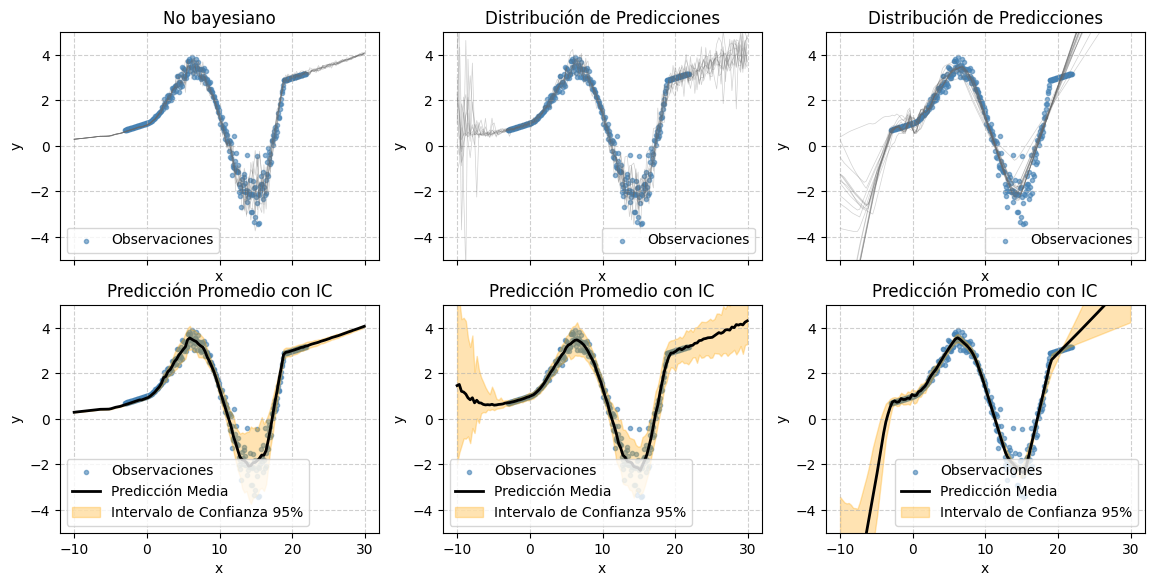

In [ ]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,3,sharex=True, sharey=False,figsize=(14,6.5))

lines = 10
lines2 = 20

make_plot_runs(ax[0,0], nobay_cpd[0:lines], ylim=[-5,5])
#make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,0].set_title('No bayesiano')
make_plot_runs_avg(ax[1,0],nobay_cpd, ylim=[-5,5])


ax[0,1].set_title('Inferencia Variacional')
make_plot_runs(ax[0,1], vi_cpd[0:lines], ylim=[-5,5])
make_plot_runs_avg(ax[1,1], vi_cpd, ylim=[-5,5])


ax[0,2].set_title('NUTS')
make_plot_runs(ax[0,2], mcmc_cpd[0:lines2], ylim=[-5,5])
make_plot_runs_avg(ax[1,2], mcmc_cpd, ylim=[-5,5])

#ax[0,0].axis('off')
#ax[1,0].axis('off')



plt.savefig('ch08_good_cpd.pdf')

plt.show()

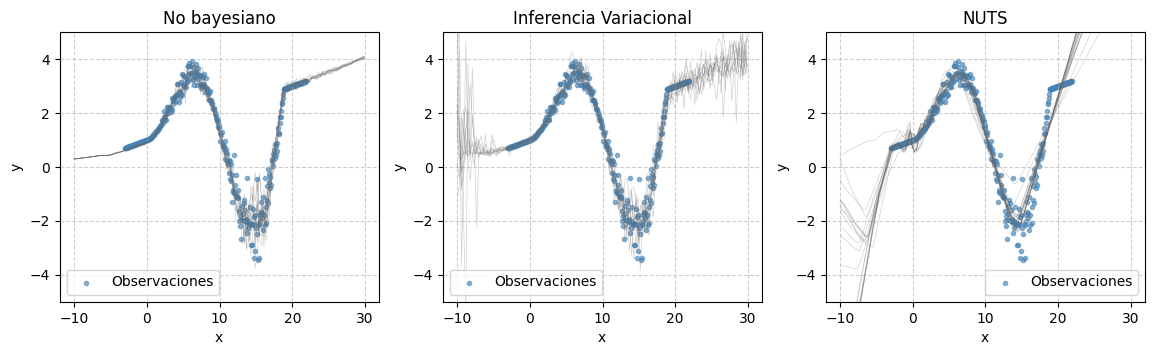

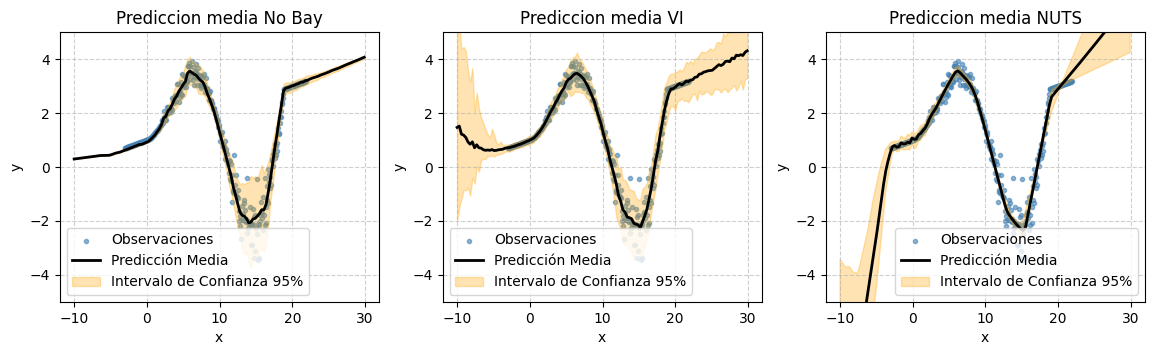

In [ ]:
import matplotlib.pyplot as plt

lines = 10
lines2 = 20

# Primera figura: Primeras 3 gráficas
fig1, ax1 = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(14, 3.5))

make_plot_runs(ax1[0], nobay_cpd[0:lines], ylim=[-5,5])
ax1[0].set_title('No bayesiano')

make_plot_runs(ax1[1], vi_cpd[0:lines], ylim=[-5,5])
ax1[1].set_title('Inferencia Variacional')

make_plot_runs(ax1[2], mcmc_cpd[0:lines2], ylim=[-5,5])
ax1[2].set_title('NUTS')

plt.savefig('ch08_good_cpd_part1.pdf')
plt.show()

# Segunda figura: Últimas 3 gráficas
fig2, ax2 = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(14, 3.5))

make_plot_runs_avg(ax2[0], nobay_cpd, ylim=[-5,5])
ax2[0].set_title('Prediccion media No Bay')

make_plot_runs_avg(ax2[1], vi_cpd, ylim=[-5,5])
ax2[1].set_title('Prediccion media VI')

make_plot_runs_avg(ax2[2], mcmc_cpd, ylim=[-5,5])
ax2[2].set_title('Prediccion media NUTS')

plt.savefig('ch08_good_cpd_part2.pdf')
plt.show()

Text(0.5, 1.0, 'Incertidumbre NUTS')

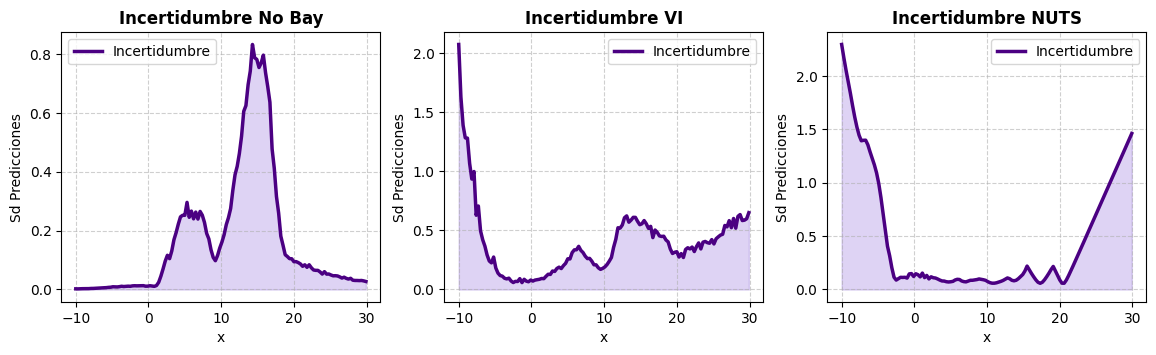

In [ ]:
def make_uncertainty_plot(ax, preds):
    """Dibuja la evolución de la incertidumbre en las predicciones con mejor estilo."""
    uncertainty = np.std(preds, axis=0)
    ax.plot(x_pred, uncertainty, color="indigo", linewidth=2.5, linestyle="-", label="Incertidumbre")
    ax.fill_between(x_pred, 0, uncertainty, color="mediumpurple", alpha=0.3)
    ax.set_xlabel("x", fontsize=10)
    ax.set_ylabel("Sd Predicciones", fontsize=10)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)


# Ejemplo de uso
fig2, ax2 = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(14, 3.5))

make_uncertainty_plot(ax2[0], nobay_cpd)
ax2[0].set_title("Incertidumbre No Bay", fontsize=12, fontweight="bold")
make_uncertainty_plot(ax2[1], vi_cpd)
ax2[1].set_title("Incertidumbre VI", fontsize=12, fontweight="bold")
make_uncertainty_plot(ax2[2], mcmc_cpd)
ax2[2].set_title("Incertidumbre NUTS", fontsize=12, fontweight="bold")

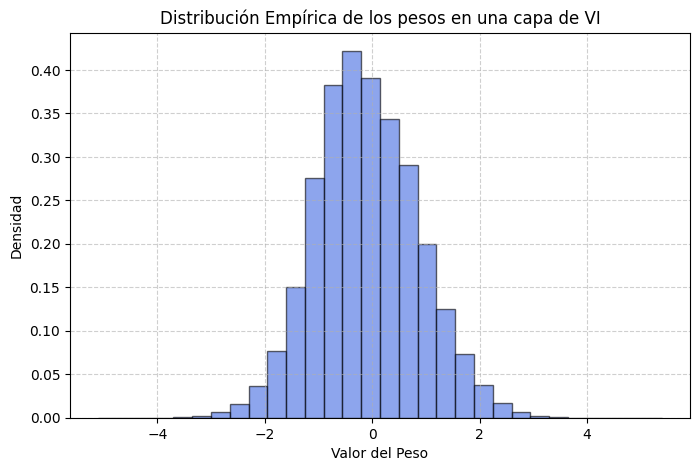

In [ ]:
vi_layer = None
i=0
for layer in model_vi.layers:
    i=i+1
    if isinstance(layer, tfp.layers.DenseFlipout) and i==3:
        vi_layer = layer
        break

if vi_layer is not None:
    # Obtener la distribución de los pesos
    kernel_posterior = vi_layer.kernel_posterior

    # Tomar muestras
    num_samples = 10000
    samples = kernel_posterior.sample(num_samples).numpy().flatten()

    # Graficar la distribución
    plt.figure(figsize=(8, 5))
    plt.hist(samples, bins=30, density=True, color="royalblue", alpha=0.6, edgecolor="black")
    plt.title("Distribución Empírica de los pesos en una capa de VI")
    plt.xlabel("Valor del Peso")
    plt.ylabel("Densidad")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

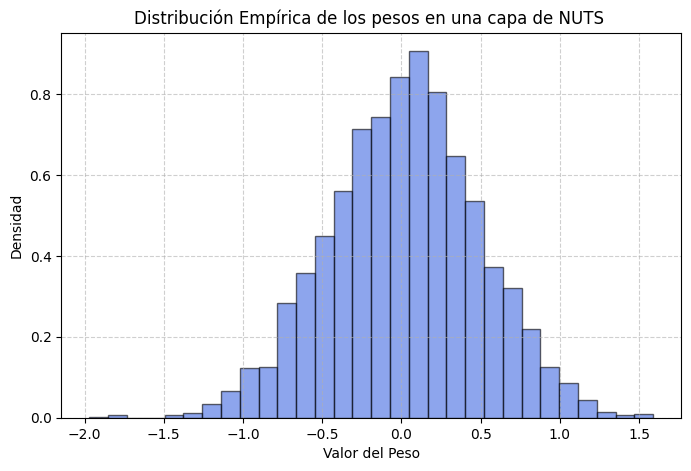

In [ ]:
# Tomar muestras de `w2` y aplanarlas
w2_samples_flattened = w2_samples.flatten()

# Graficar la distribución de uno de los pesos de la capa w2
plt.figure(figsize=(8, 5))
plt.hist(w2_samples_flattened, bins=30, density=True, color="royalblue", alpha=0.6, edgecolor="black")
plt.title("Distribución Empírica de los pesos en una capa de NUTS ")
plt.xlabel("Valor del Peso")
plt.ylabel("Densidad")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

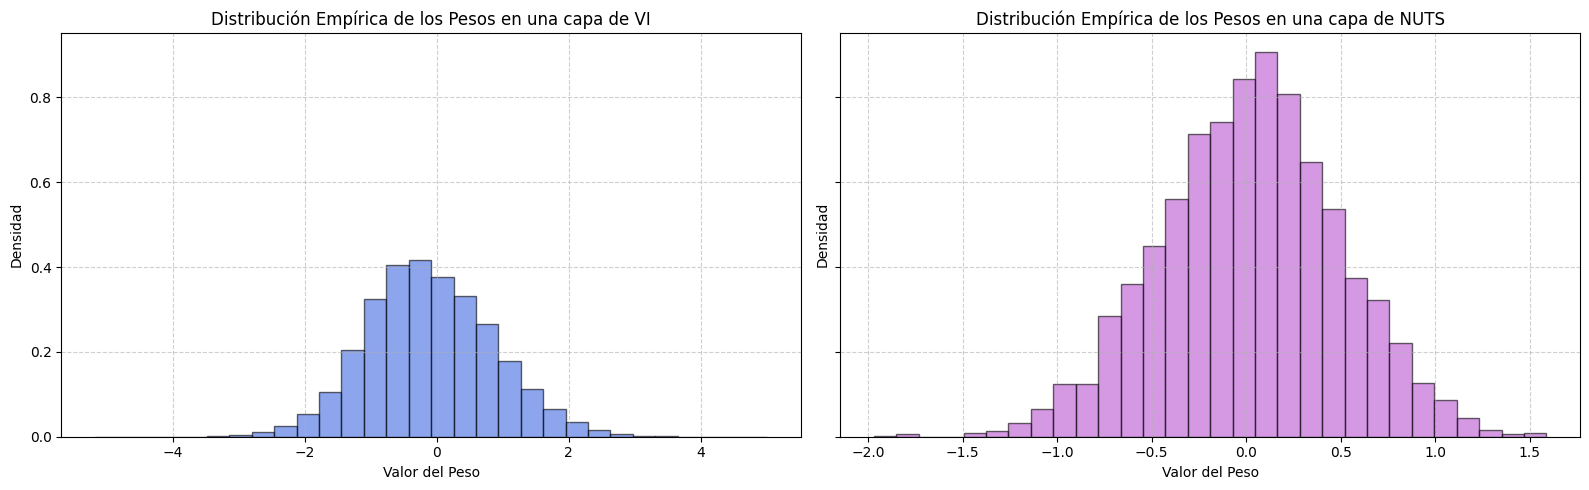

In [ ]:
vi_layer = None
i = 0

# Buscar la capa específica en el modelo VI
for layer in model_vi.layers:
    i += 1
    if isinstance(layer, tfp.layers.DenseFlipout) and i == 3:
        vi_layer = layer
        break

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

if vi_layer is not None:
    # Obtener muestras de VI
    kernel_posterior = vi_layer.kernel_posterior
    num_samples = 10000
    samples_vi = kernel_posterior.sample(num_samples).numpy().flatten()

    # Graficar distribución VI
    axes[0].hist(samples_vi, bins=30, density=True, color="royalblue", alpha=0.6, edgecolor="black")
    axes[0].set_title("Distribución Empírica de los Pesos en una capa de VI")
    axes[0].set_xlabel("Valor del Peso")
    axes[0].set_ylabel("Densidad")
    axes[0].grid(True, linestyle="--", alpha=0.6)

# Graficar distribución NUTS
w2_samples_flattened = w2_samples.flatten()
axes[1].hist(w2_samples_flattened, bins=30, density=True, color="mediumorchid", alpha=0.6, edgecolor="black")
axes[1].set_title("Distribución Empírica de los Pesos en una capa de NUTS")
axes[1].set_xlabel("Valor del Peso")
axes[1].set_ylabel("Densidad")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
